##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Processing datasets with the Batch API

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Datasets.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

This notebook shows you how to process a downloaded JSONL dataset using the Batch API. To use it you will need to have logging enabled and have collected some logs into a dataset. For details on this process check out the [Logging and Datasets docs](https://ai.google.dev/gemini-api/docs/logs-datasets).

## Get set up

Install the SDK and get authenticated.

In [ ]:
%pip install -q "google-genai>=1.34.0"

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication ![image](https://storage.googleapis.com/generativeai-downloads/images/colab_icon16.png)](../quickstarts/Authentication.ipynb) for an example.

In [ ]:
from google.colab import userdata

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GEMINI_API_KEY)

## Add your dataset

To download your dataset, visit the [AI Studio logs dashboard](https://aistudio.google.com/logs), select your project and dataset and choose `Export dataset` in `JSONL` format.

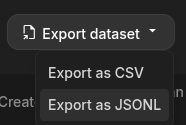

In the next step, you will upload the JSONL file to this notebook for processing.

In [ ]:
import pathlib

dataset_path = pathlib.Path("dataset.jsonl")

upload_json = True
if upload_json:
  from google.colab import files
  files.upload_file(filename=str(dataset_path))
else:
  # Alternatively, you can try the system out with these sample logs.
  !wget https://storage.googleapis.com/generativeai-downloads/data/spam_dataset.jsonl -O {dataset_path}

Saved dataset.jsonl to /content/dataset.jsonl


## Evaluate against different models

Here you will perform an analysis of this dataset against 2 different models. For this exercise, the existing outputs and model names will be cleared, as the Batch API requires the model name to be uniform throughout each batch, while datasets can be assembled from multiple models.

In [ ]:
import json
from typing import Iterator


def with_no_model_no_response(ds_path: pathlib.Path) -> Iterator[str]:
  for row in ds_path.open():
    data = json.loads(row)
    # Clear the model field. Batches require homogenous models.
    data['request'].pop('model', None)
    # This example will compare two batches, so existing responses can be discarded.
    data.pop('response', None)
    yield json.dumps(data)


clean_dataset = pathlib.Path('clear_dataset.jsonl')

with clean_dataset.open("w") as f:
  for line in with_no_model_no_response(dataset_path):
    print(line, file=f)

Now upload the scrubbed dataset through the File API so it can be used for inference.

In [ ]:
clean_dataset_ref = client.files.upload(
    file=clean_dataset,
    config=types.UploadFileConfig(
        display_name='eval dataset',
        mime_type='application/json'
    )
)

print(f"Uploaded file: {clean_dataset_ref.name}")

Uploaded file: files/ej2yk0lw3298


Now define and start the batches. This example will run a batch against Gemini 2.5 Flash and Pro.

In [ ]:
models_to_eval = ['gemini-2.5-flash', 'gemini-2.5-pro']

batches = []
for model in models_to_eval:
  batch_ref = client.batches.create(
      model=model,
      # Reuse the same dataset across batches.
      src=clean_dataset_ref.name,
      config=types.CreateBatchJobConfig(
          display_name=f'Resubmit of dataset with {model}'
      )
  )

  print(f"Created batch job from file: {batch_ref.name}")
  batches.append(batch_ref)

Created batch job from file: batches/6u50zzu2d9xf639ic6pmdmb7s8opo9mtskie
Created batch job from file: batches/1hjav84vzv50ld9oeev416my3bvc44aesr8c


Wait for the batches to finish. This can take up to 24 hours to complete.

In [ ]:
import time

remaining = {b.name for b in batches}
while remaining:
  for batch in batches:
    if batch.name not in remaining:
      continue

    # Poll for the batch status.
    batch_job = client.batches.get(name=batch.name)

    # Success?
    if batch_job.state.name == 'JOB_STATE_SUCCEEDED':
      print(f'COMPLETE: {batch.name}')
      remaining.remove(batch.name)

    # Failure?
    elif batch_job.state.name in {'JOB_STATE_FAILED', 'JOB_STATE_CANCELLED'}:
      print(f'ERROR: {batch.name}')
      remaining.remove(batch.name)

    # Otherwise still pending.
    time.sleep(30)

When the results are complete, download the resulting data.

In [ ]:
result_files = []
for i, batch in enumerate(batches, start=1):
  batch_job = client.batches.get(name=batch.name)

  result_file_name = batch_job.dest.file_name

  file_content_bytes = client.files.download(file=result_file_name)
  file_content = file_content_bytes.decode('utf-8')

  result_file = pathlib.Path(f'results_{i}.jsonl')
  result_file.write_text(file_content)

  result_files.append(result_file)

To compare the results you will need an evaluation function. In practice you may evaluate in one of many ways (e.g. by comparison, by using LLMs). This example assumes the model should invoke a function call to be correct.

Update `is_correct` to match your evaluation criteria, returning `True` when the result is good, and `False` otherwise.

In [ ]:
def is_correct(row) -> bool:
  try:
    return 'functionCall' in row['response']['candidates'][0]['content']['parts'][-1]
  except (KeyError, IndexError):
    return False


for i, file in enumerate(result_files):
  with file.open() as f:
    file_score = 0
    total_count = 0
    for row in f:
      data = json.loads(row)

      file_score += int(is_correct(data))
      total_count += 1

    model = models_to_eval[i]
    if total_count:
      print(f'{model}: {file_score / total_count:.2%}')
    else:
      print(f'No results found for {model}')

gemini-2.5-flash: 53.33%
gemini-2.5-pro: 93.33%


## Next steps

For more on Logging and Datasets, check out:
* The [Logging and Datasets docs](https://ai.google.dev/gemini-api/docs/logs-datasets)
* The [Batch API cookbook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Batch_mode.ipynb)